In [268]:
%matplotlib inline
import os
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import scipy.stats as stats
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
import datetime as dt
from pandas.tseries.offsets import MonthBegin
from pandas.plotting import scatter_matrix

In [2]:
df_raw=pd.read_csv('2017_10_csv.csv')

In [3]:
idfeat = pd.read_csv('ID_feature_csv.csv')
idfeat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 5 columns):
ID                   30000 non-null object
Contractual_power    30000 non-null float64
Phases               30000 non-null object
Macrocluster         30000 non-null object
PV_generation        30000 non-null object
dtypes: float64(1), object(4)
memory usage: 1.1+ MB


In [4]:
# Let's create a sample to work with efficiently.

df = df_raw.sample(frac=0.05, replace=False, random_state=42)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579381 entries, 7814657 to 8871159
Data columns (total 4 columns):
id          579381 non-null object
yyyymmdd    579381 non-null object
hh          579381 non-null int64
consumo     579381 non-null int64
dtypes: int64(2), object(2)
memory usage: 22.1+ MB


In [6]:
#Let's create a timestamp to identify duplicate values

#df.drop(columns='hora',inplace=True)
df.hora=df.hh.astype(str)
df['DateTime'] = pd.to_datetime(df['yyyymmdd'] + ' ' + df.hora + ':00:00')

df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


id    yyyymmdd  hh  consumo            DateTime
7814657  ID02196  2017-10-24  16      289 2017-10-24 16:00:00
1687468  ID15274  2017-10-26   4      434 2017-10-26 04:00:00
431115   ID07681  2017-10-08  10        0 2017-10-08 10:00:00
7469643  ID11134  2017-10-08  11      124 2017-10-08 11:00:00
2011870  ID21961  2017-10-18  20      369 2017-10-18 20:00:00

In [7]:
# Let's drop duplicate values.

dupli=df[df[['id','DateTime']].duplicated()]
print(dupli.shape)
print(dupli.head(20))

(11, 5)
               id    yyyymmdd  hh  consumo            DateTime
7849554   ID03477  2017-10-17   8      317 2017-10-17 08:00:00
317478    ID00304  2017-10-02   5      993 2017-10-02 05:00:00
1200284   ID00075  2017-10-18  14       85 2017-10-18 14:00:00
10734907  ID00101  2017-10-24  23      129 2017-10-24 23:00:00
10240275  ID00862  2017-10-06  22       83 2017-10-06 22:00:00
1201105   ID00075  2017-10-12   2      348 2017-10-12 02:00:00
1200249   ID00075  2017-10-02  13      862 2017-10-02 13:00:00
10239607  ID00862  2017-10-01  12      137 2017-10-01 12:00:00
7849241   ID03477  2017-10-02   8      100 2017-10-02 08:00:00
4383317   ID22623  2017-10-05   6      100 2017-10-05 06:00:00
4382751   ID22623  2017-10-06  15      147 2017-10-06 15:00:00


In [8]:
# Let's make sure what we identified is a duplicate value.

print(df[(df.id=='ID00304')&(df.DateTime=='2017-10-02 05:00:00')])

             id    yyyymmdd  hh  consumo            DateTime
292605  ID00304  2017-10-02   5     1374 2017-10-02 05:00:00
317478  ID00304  2017-10-02   5      993 2017-10-02 05:00:00


In [9]:
# Removing duplicate values and comparing.

df_wod=df[~df[['id','DateTime']].duplicated()]
print(df.shape,df_wod.shape)

(579381, 5) (579370, 5)


In [10]:
# Let's join the internal features now with the our consumption dataset

df_m=df_wod.set_index('id').join(idfeat.set_index('ID'), how='left')

In [11]:
df_m.head()

yyyymmdd  hh  consumo            DateTime  Contractual_power  \
ID00009  2017-10-05  23     1833 2017-10-05 23:00:00                2.5   
ID00009  2017-10-12  14      688 2017-10-12 14:00:00                2.5   
ID00009  2017-10-02   9       78 2017-10-02 09:00:00                2.5   
ID00009  2017-10-24  11       81 2017-10-24 11:00:00                2.5   
ID00009  2017-10-08   7       78 2017-10-08 07:00:00                2.5   

        Phases              Macrocluster PV_generation  
ID00009      M  Small Enterprise - Other            NO  
ID00009      M  Small Enterprise - Other            NO  
ID00009      M  Small Enterprise - Other            NO  
ID00009      M  Small Enterprise - Other            NO  
ID00009      M  Small Enterprise - Other            NO

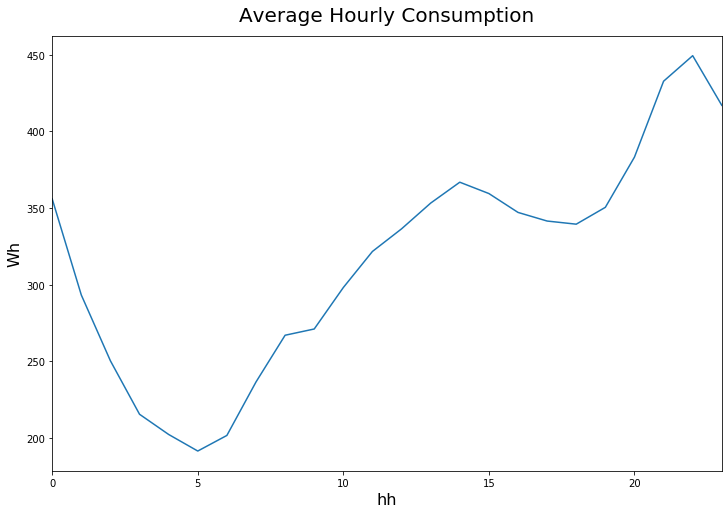

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title("Average Hourly Consumption", fontsize=20, y=1.02)
ax.set_ylabel("Wh", fontsize=16)
ax.set_xlabel("Hour", fontsize=16)

df.groupby('hh').consumo.mean().plot(kind='line')

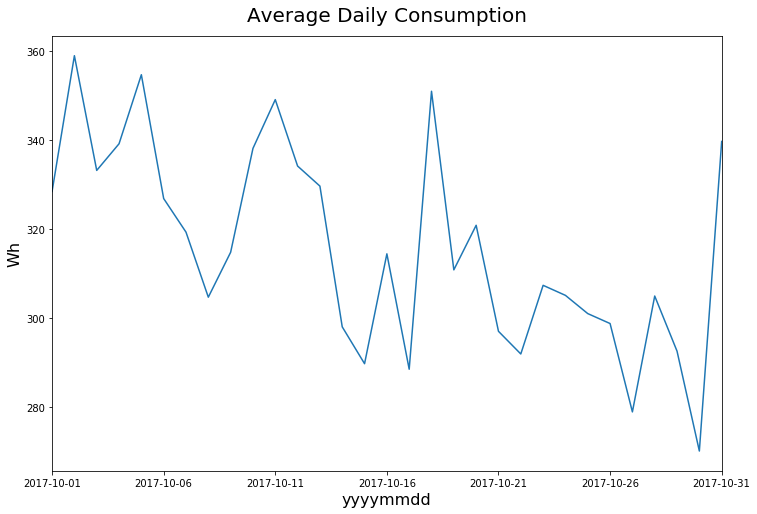

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title("Average Daily Consumption", fontsize=20, y=1.02)
ax.set_ylabel("Wh", fontsize=16)
ax.set_xlabel("Hour", fontsize=16)

df.groupby('yyyymmdd').consumo.mean().plot(kind='line')

In [16]:
# Now, in order to measure correlation between all variables, 
# we have to convert our categorical variables into an encoded variable.

cat_features=['Phases','Macrocluster','PV_generation']
ohe = OneHotEncoder()
ohe.fit_transform(df_m[cat_features])
categories = ohe.categories_

one_hot_enc = ce.OneHotEncoder()
one_hot_encoded = one_hot_enc.fit_transform(df_m[cat_features])
df_ohe = df_m.join(one_hot_encoded.add_suffix("_oh"))

print(categories, df_ohe.columns)

[array(['M', 'T'], dtype=object), array(['HOUSEHOLD', 'Public offices', 'Small Enterprise - Other',
       'Small Enterprise - Retail', 'Small Enterprise - other',
       'Small Enterprise - retail',
       'Uncertain Household or Small Enterprise'], dtype=object), array(['NO', 'Yes installed in 2016', 'Yes installed in 2017',
       'Yes installed in 2018', 'Yes installed in 2019',
       'Yes installed in 2020'], dtype=object)] Index(['yyyymmdd', 'hh', 'consumo', 'DateTime', 'Contractual_power', 'Phases',
       'Macrocluster', 'PV_generation', 'Phases_1_oh', 'Phases_2_oh',
       'Macrocluster_1_oh', 'Macrocluster_2_oh', 'Macrocluster_3_oh',
       'Macrocluster_4_oh', 'Macrocluster_5_oh', 'Macrocluster_6_oh',
       'Macrocluster_7_oh', 'PV_generation_1_oh', 'PV_generation_2_oh',
       'PV_generation_3_oh', 'PV_generation_4_oh', 'PV_generation_5_oh',
       'PV_generation_6_oh'],
      dtype='object')


In [17]:
# Now we can check the correlation of Internal Features

plt.figure(figsize=(20,20))
cm= df_ohe.corr()
hm = sns.heatmap(cm, annot=True, fmt='.2f', cmap="YlGn")
hm.set_title('Correlation Matrix', fontsize=20, y=1.02)

#plt.savefig("client_feat_corr.png")

plt.show()

In [18]:
cm['consumo'].sort_values(ascending=False)

consumo               1.000000
hh                    0.139182
Macrocluster_4_oh     0.086992
Contractual_power     0.082755
Macrocluster_1_oh     0.072078
Phases_2_oh           0.042749
Macrocluster_6_oh     0.035149
Macrocluster_7_oh     0.024689
Macrocluster_3_oh     0.023440
PV_generation_5_oh    0.016507
Macrocluster_5_oh     0.016011
PV_generation_2_oh    0.006235
PV_generation_3_oh    0.006118
PV_generation_6_oh    0.004455
PV_generation_4_oh    0.000173
PV_generation_1_oh   -0.014930
Phases_1_oh          -0.042749
Macrocluster_2_oh    -0.123366
Name: consumo, dtype: float64

In [50]:
# Let's bring in the external features
# Let's see the name of the sheets

import xlrd
xls = xlrd.open_workbook(r'TempSantigo.xlsx', on_demand=True)
print(xls.sheet_names()) 

['temp-pres', 'sunset-rise', 'holidays', 'sunlight']


In [199]:
# Let's load the sheets

extF_t = pd.read_excel('TempSantigo.xlsx', sheet_name='temp-pres')
extF_t.rename(columns={"cobmox(combination of date and hour)":"DateTime"},inplace=True)
extF_sr = pd.read_excel('TempSantigo.xlsx', sheet_name='sunset-rise')
extF_h = pd.read_excel('TempSantigo.xlsx', sheet_name='holidays', names=['date','holiday_name','type'])
extF_s = pd.read_excel('TempSantigo.xlsx', sheet_name='sunlight')
extF_s.rename(columns={"cobmox(combination of date and hour)":"DateTime"},inplace=True)
print(extF_t.columns)
print(extF_sr.columns)
print(extF_h.columns)
print(extF_s.columns)

Index(['date', 'hour', 'DateTime', 'temp', 'feels_like', 'temp_min',
       'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h',
       'snow_1h', 'clouds_all', 'weather_description'],
      dtype='object')
Index(['Date', 'Sunrise', 'Sunset', 'lengthofday', 'Daylength'], dtype='object')
Index(['date', 'holiday_name', 'type'], dtype='object')
Index(['Date', 'Hour', 'DateTime', 'Tamb', 'Azimuth', 'Cloudopacity', 'DHI',
       'DNI', 'EBH', 'GHI', 'Zenith'],
      dtype='object')


In [46]:
# And cross reference them to our energy consuption by timestamp

cons = df.groupby(['DateTime']).consumo.mean().to_frame()
cons = cons.reset_index()
cons.head()
cons.DateTime = pd.to_datetime(cons.DateTime)
df_mext_t = cons.join(extF_t, how='left', rsuffix='_extF')
df_mext_t.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 17 columns):
DateTime               744 non-null datetime64[ns]
consumo                744 non-null float64
date                   744 non-null datetime64[ns]
hour                   744 non-null datetime64[ns]
DateTime_extF          744 non-null datetime64[ns]
temp                   744 non-null float64
feels_like             744 non-null float64
temp_min               744 non-null float64
temp_max               744 non-null float64
pressure               744 non-null int64
humidity               744 non-null int64
wind_speed             744 non-null float64
wind_deg               744 non-null int64
rain_1h                8 non-null float64
snow_1h                0 non-null float64
clouds_all             744 non-null int64
weather_description    744 non-null object
dtypes: datetime64[ns](4), float64(8), int64(4), object(1)
memory usage: 98.9+ KB


In [39]:
# Let's encode the categorical values in our external factors now

qual = ['weather_description']
ohe_e = OneHotEncoder()
ohe_e.fit_transform(df_mext_t[qual])
categories_e = ohe_e.categories_

one_hot_enc_e = ce.OneHotEncoder()
one_hot_encoded_e = one_hot_enc_e.fit_transform(df_mext_t['weather_description'])
df_ohe_e = df_mext_t.join(one_hot_encoded_e.add_suffix("_oh"))

print(categories, df_ohe_e.columns)

[array(['M', 'T'], dtype=object), array(['HOUSEHOLD', 'Public offices', 'Small Enterprise - Other',
       'Small Enterprise - Retail', 'Small Enterprise - other',
       'Small Enterprise - retail',
       'Uncertain Household or Small Enterprise'], dtype=object), array(['NO', 'Yes installed in 2016', 'Yes installed in 2017',
       'Yes installed in 2018', 'Yes installed in 2019',
       'Yes installed in 2020'], dtype=object)] Index(['DateTime', 'consumo', 'date', 'hour', 'DateTime_extF', 'temp',
       'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'snow_1h', 'clouds_all',
       'weather_description', 'weather_description_1_oh',
       'weather_description_2_oh', 'weather_description_3_oh',
       'weather_description_4_oh', 'weather_description_5_oh',
       'weather_description_6_oh', 'weather_description_7_oh',
       'weather_description_8_oh', 'weather_description_9_oh',
       'weather_description_10_oh', 'weather_de

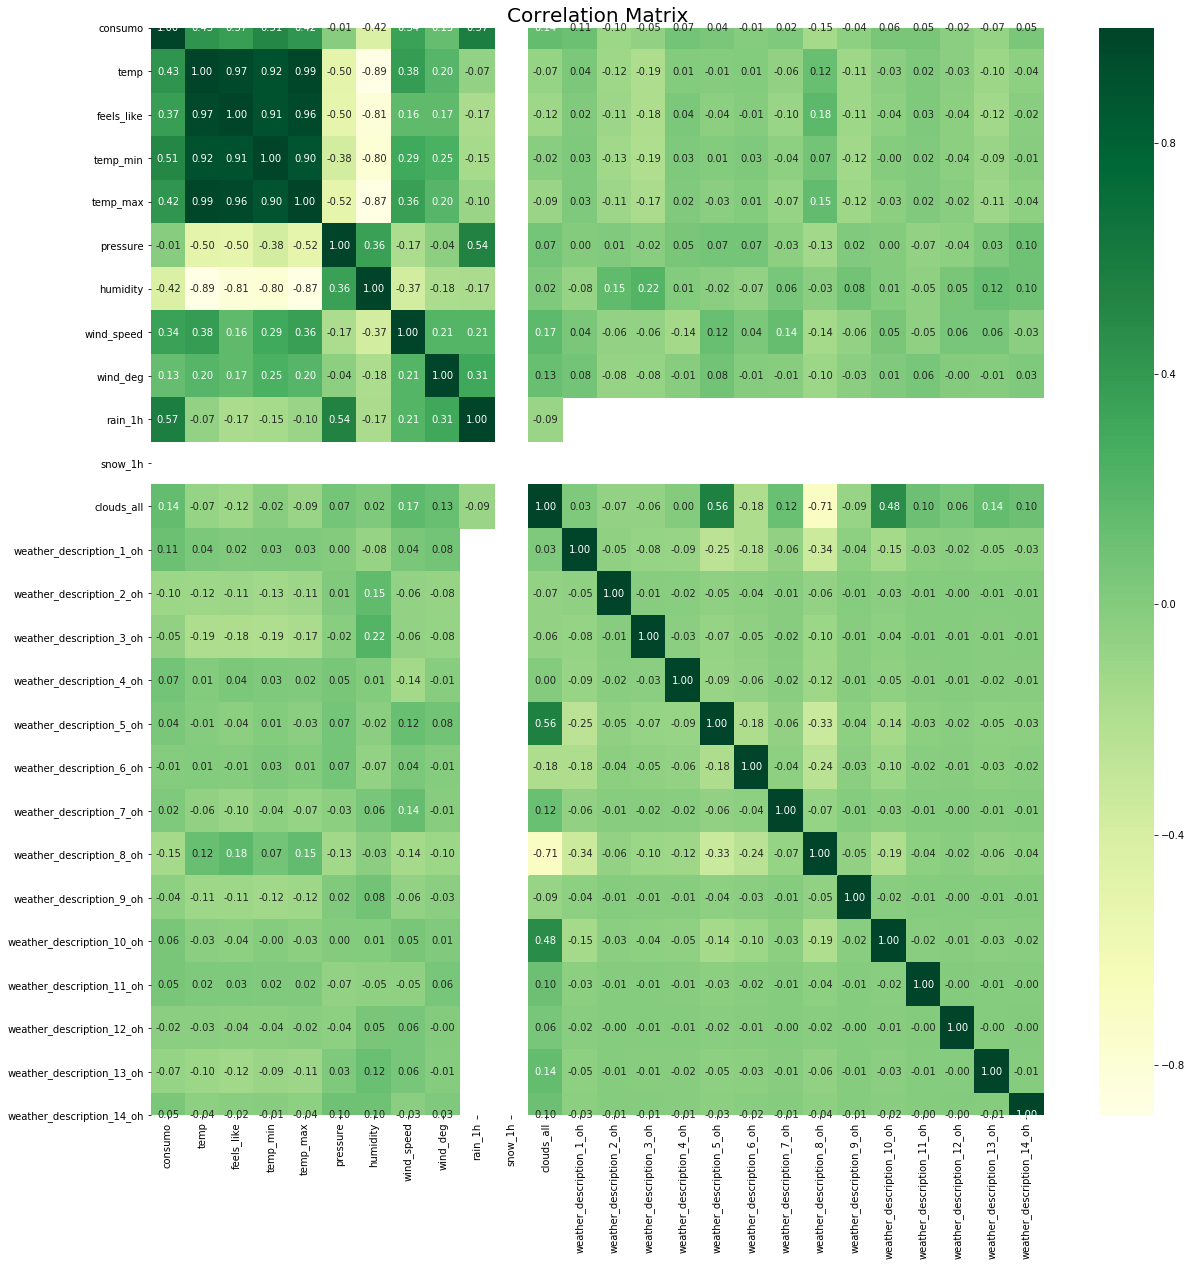

In [64]:
# Correlation External Features (Temp)

plt.figure(figsize=(20,20))
cm_e_t= df_ohe_e.corr()
hm = sns.heatmap(cm_e_t, annot=True, fmt='.2f', cmap="YlGn")
hm.set_title('Correlation Matrix', fontsize=20, y=1.02)

#plt.savefig("external_feat_corr.png")

plt.show()

In [65]:
cm_e_t['consumo'].sort_values(ascending=False)

consumo                      1.000000
rain_1h                      0.572752
temp_min                     0.508438
temp                         0.429858
temp_max                     0.423368
feels_like                   0.371513
wind_speed                   0.344865
clouds_all                   0.143419
wind_deg                     0.134959
weather_description_1_oh     0.111169
weather_description_4_oh     0.074994
weather_description_10_oh    0.056244
weather_description_11_oh    0.051413
weather_description_14_oh    0.047415
weather_description_5_oh     0.043687
weather_description_7_oh     0.021019
weather_description_6_oh    -0.009087
pressure                    -0.011222
weather_description_12_oh   -0.024544
weather_description_9_oh    -0.043642
weather_description_3_oh    -0.054067
weather_description_13_oh   -0.074553
weather_description_2_oh    -0.099874
weather_description_8_oh    -0.145977
humidity                    -0.421561
snow_1h                           NaN
Name: consum

In [61]:
# Let's cross reference sunrise information to our energy consuption by timestamp

cons = df.groupby(['DateTime']).consumo.mean().to_frame()
cons = cons.reset_index()
cons.head()
cons.DateTime = pd.to_datetime(cons.DateTime)
df_mext_s = cons.join(extF_s, how='left', rsuffix='_extF')
df_mext_s.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 13 columns):
DateTime         744 non-null datetime64[ns]
consumo          744 non-null float64
Date             744 non-null datetime64[ns]
Hour             744 non-null int64
DateTime_extF    744 non-null datetime64[ns]
Tamb             744 non-null float64
Azimuth          744 non-null int64
Cloudopacity     744 non-null float64
DHI              744 non-null int64
DNI              744 non-null int64
EBH              744 non-null int64
GHI              744 non-null int64
Zenith           744 non-null int64
dtypes: datetime64[ns](3), float64(3), int64(7)
memory usage: 75.7 KB


In [309]:
# Correlation lines

m, b = np.polyfit(df_mext_s.Zenith, df_mext_s.consumo, 1)
sns.relplot(x="Zenith",  y = 'consumo',  kind="scatter",  data =df_mext_s)
plt.plot(df_mext_s.Zenith, m*df_mext_s.Zenith + b, color='r')

plt.savefig("zenith_consumo_corr.png");

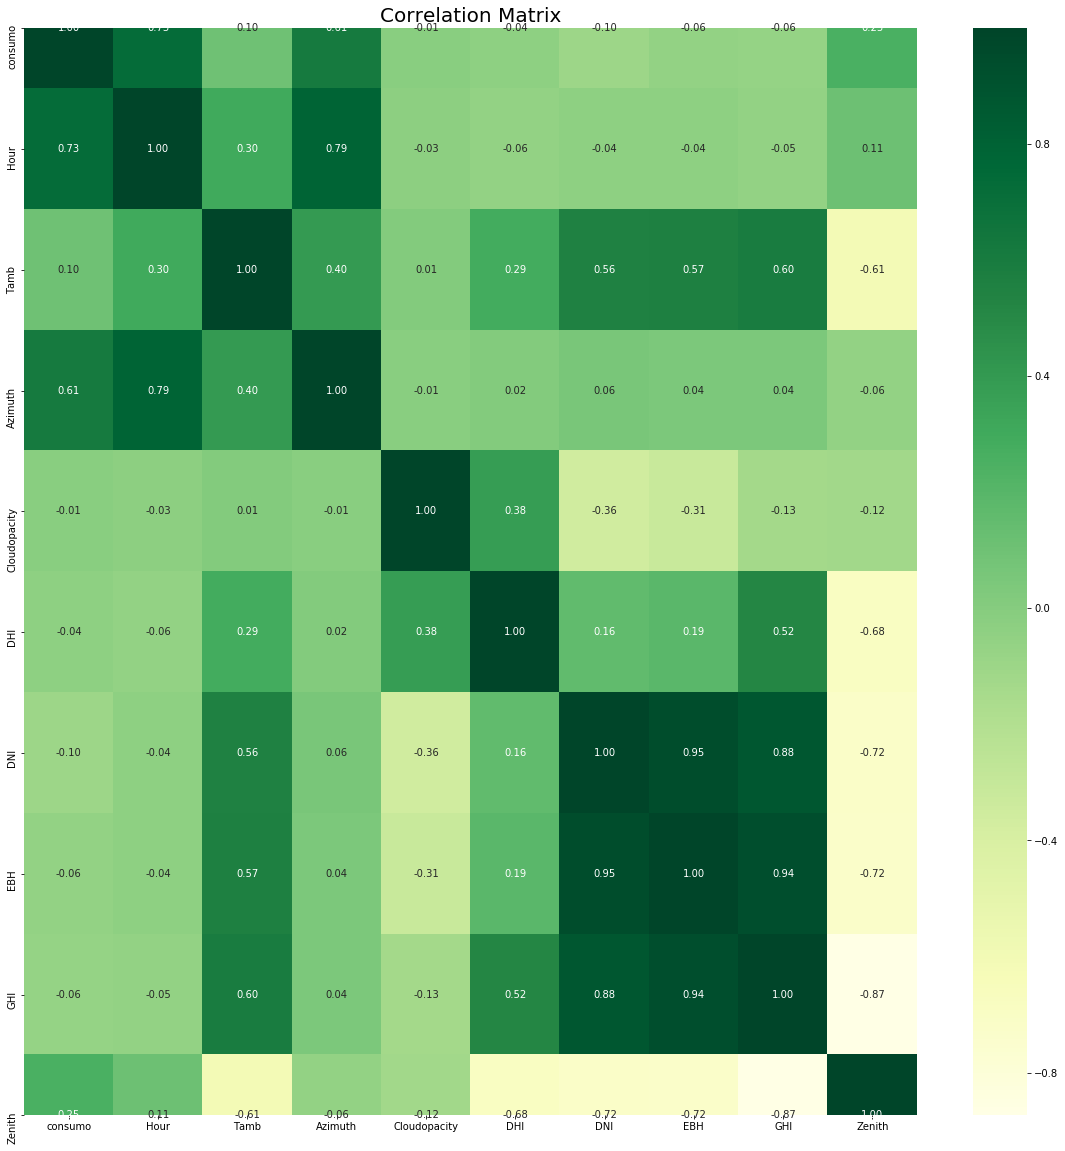

In [63]:
# Correlation External Sunrise Features

plt.figure(figsize=(20,20))
cm_e_s= df_mext_s.corr()
hm = sns.heatmap(cm_e_s, annot=True, fmt='.2f', cmap="YlGn")
hm.set_title('Correlation Matrix', fontsize=20, y=1.02)

#plt.savefig("external_feat_corr.png")

plt.show()

In [274]:
scatter_matrix(cm_e_s, figsize = (12,8));

In [66]:
cm_e_s['consumo'].sort_values(ascending=False)

consumo         1.000000
Hour            0.729941
Azimuth         0.614530
Zenith          0.253643
Tamb            0.100512
Cloudopacity   -0.012901
DHI            -0.038171
EBH            -0.055361
GHI            -0.061763
DNI            -0.102728
Name: consumo, dtype: float64

In [144]:
# Holiday Analysis - we break up the initial tab into two

cons_srh = df.groupby(['yyyymmdd']).consumo.mean().to_frame()
cons_srh = cons_srh.reset_index()
#cons_srh.duplicated()
cons_srh.yyyymmdd = pd.to_datetime(cons_srh.yyyymmdd)
df_mext_h = pd.merge(cons_srh,extF_h,left_on=['yyyymmdd'], right_on=['date'], how='left')
df_mext_h.head(30)

yyyymmdd     consumo       date     holiday_name              type
0  2017-10-01  328.373816        NaT              NaN               NaN
1  2017-10-02  358.849980        NaT              NaN               NaN
2  2017-10-03  333.099130        NaT              NaN               NaN
3  2017-10-04  339.075658        NaT              NaN               NaN
4  2017-10-05  354.576221        NaT              NaN               NaN
5  2017-10-06  326.780832        NaT              NaN               NaN
6  2017-10-07  319.240817        NaT              NaN               NaN
7  2017-10-08  304.640112        NaT              NaN               NaN
8  2017-10-09  314.719948        NaT              NaN               NaN
9  2017-10-10  338.036356        NaT              NaN               NaN
10 2017-10-11  348.987500        NaT              NaN               NaN
11 2017-10-12  334.080617        NaT              NaN               NaN
12 2017-10-13  329.573374        NaT              NaN               NaN
13 2017-10-14  297.979583        NaT              NaN               NaN
14 2017-10-15  289.708282        NaT              NaN               NaN
15 2017-10-16  314.372079        NaT              NaN               NaN
16 2017-10-17  288.467314        NaT              NaN               NaN
17 2017-10-18  350.863929        NaT              NaN               NaN
18 2017-10-19  310.775813        NaT              NaN               NaN
19 2017-10-20  320.780437        NaT              NaN               NaN
20 2017-10-21  296.980559        NaT              NaN               NaN
21 2017-10-22  291.890439        NaT              NaN               NaN
22 2017-10-23  307.302582        NaT              NaN               NaN
23 2017-10-24  305.047565        NaT              NaN               NaN
24 2017-10-25  300.956509        NaT              NaN               NaN
25 2017-10-26  298.725605        NaT              NaN               NaN
26 2017-10-27  278.890935 2017-10-27  Reformation Day  National holiday
27 2017-10-28  304.901786        NaT              NaN               NaN
28 2017-10-29  292.524572        NaT              NaN               NaN
29 2017-10-30  270.104981        NaT              NaN               NaN

In [145]:
df_mext_h.drop(columns='date', inplace=True)

In [146]:
# We treat the nulls

df_mext_h.holiday_name.fillna('nah', inplace=True)
df_mext_h.type.fillna('nah', inplace=True)
df_mext_h.head()

yyyymmdd     consumo holiday_name type
0 2017-10-01  328.373816          nah  nah
1 2017-10-02  358.849980          nah  nah
2 2017-10-03  333.099130          nah  nah
3 2017-10-04  339.075658          nah  nah
4 2017-10-05  354.576221          nah  nah

In [147]:
# Now, in order to measure correlation between all variables, 
# we have to convert our categorical variables into an encoded variable.

cat_features_h=['holiday_name','type']
ohe = OneHotEncoder()
ohe.fit_transform(df_mext_h[cat_features_h])
categories_h = ohe.categories_

one_hot_enc_h = ce.OneHotEncoder()
one_hot_encoded_h = one_hot_enc_h.fit_transform(df_mext_h[cat_features_h])
df_ohe_h = df_mext_h.join(one_hot_encoded_h.add_suffix("_oh"))

print(categories_h, df_ohe_h.columns)

[array(['Reformation Day', 'nah'], dtype=object), array(['National holiday', 'nah'], dtype=object)] Index(['yyyymmdd', 'consumo', 'holiday_name', 'type', 'holiday_name_1_oh',
       'holiday_name_2_oh', 'type_1_oh', 'type_2_oh'],
      dtype='object')


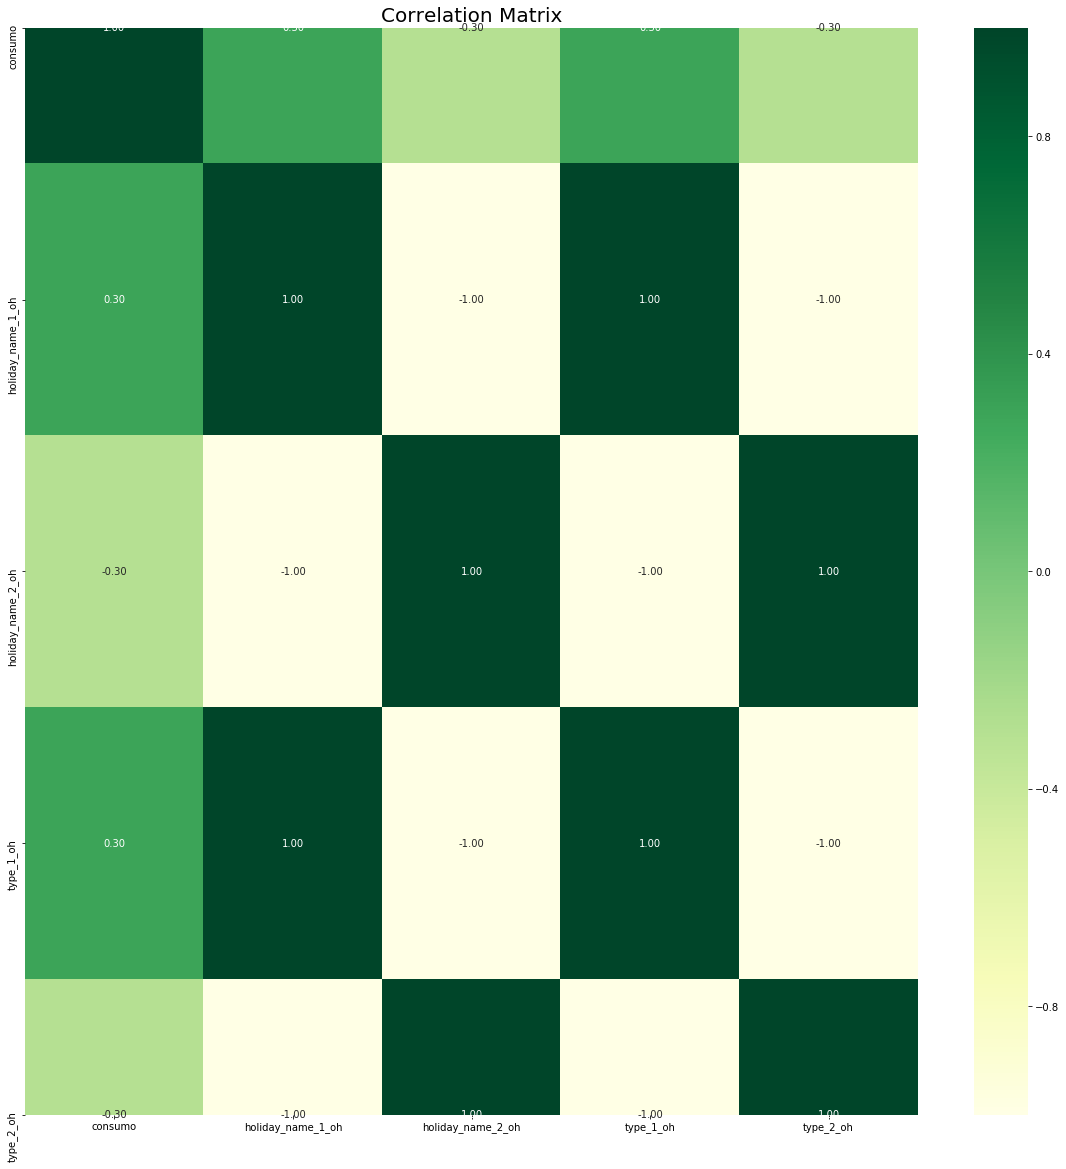

In [148]:
# Correlation External Holiday Features

plt.figure(figsize=(20,20))
cm_e_h= df_ohe_h.corr()
hm = sns.heatmap(cm_e_h, annot=True, fmt='.2f', cmap="YlGn")
hm.set_title('Correlation Matrix', fontsize=20, y=1.02)

#plt.savefig("external_feat_corr.png")

plt.show()

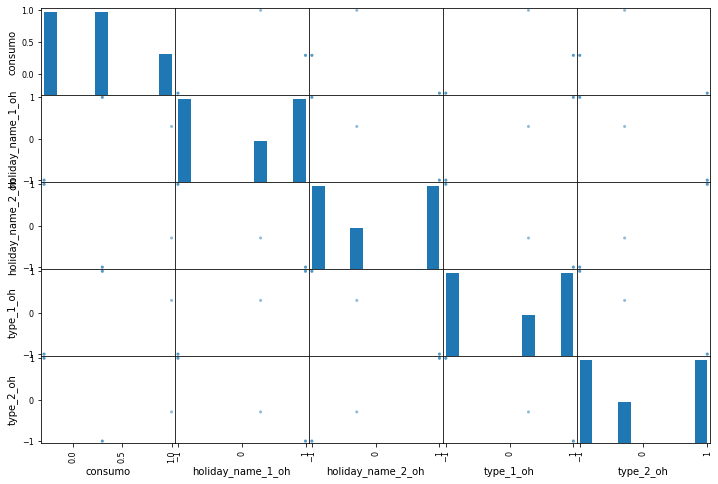

In [275]:
scatter_matrix(cm_e_h, figsize = (12,8));

In [149]:
cm_e_h['consumo'].sort_values(ascending=False)

consumo              1.000000
type_1_oh            0.296055
holiday_name_1_oh    0.296055
type_2_oh           -0.296055
holiday_name_2_oh   -0.296055
Name: consumo, dtype: float64

In [308]:
# Sunrise data, please note we modified the excel to make
# the length of the day equivalent to a numeral value
df_mext_sr.head()

yyyymmdd     consumo       Date   Sunrise    Sunset  lengthofday Daylength
0 2017-10-01  328.373816 2017-10-01  07:19:00  19:45:00    12.000556  12:26:02
1 2017-10-02  358.849980 2017-10-02  07:18:00  19:46:00    12.001389  12:28:05
2 2017-10-03  333.099130 2017-10-03  07:16:00  19:46:00    12.002500  12:30:09
3 2017-10-04  339.075658 2017-10-04  07:15:00  19:47:00    12.003611  12:32:13
4 2017-10-05  354.576221 2017-10-05  07:14:00  19:48:00    12.004444  12:34:16

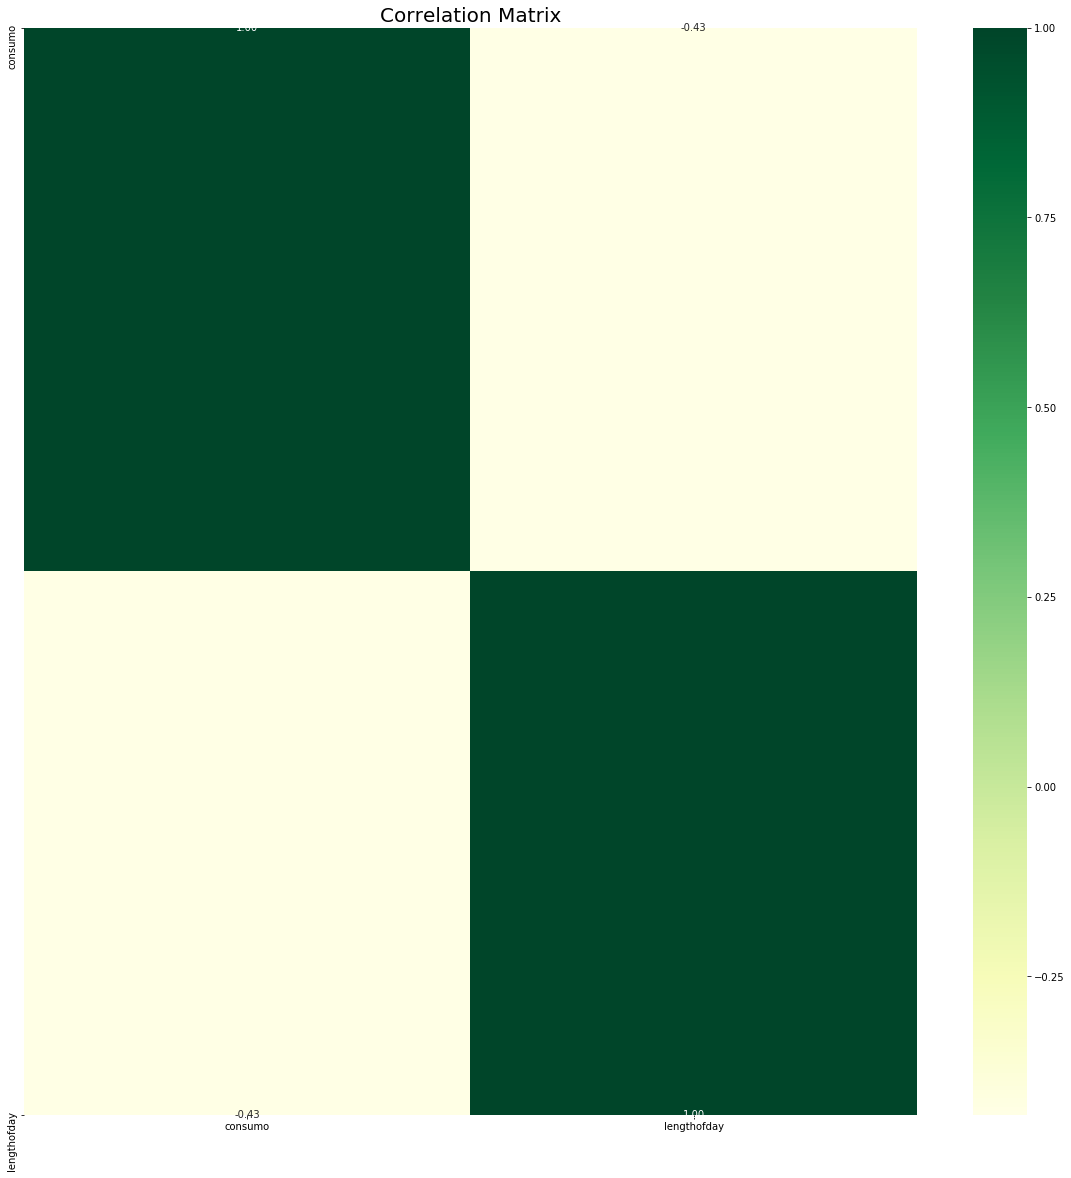

In [201]:
# Lets merge our daylength dataset


df_mext_sr = pd.merge(cons_srh,extF_sr,left_on=['yyyymmdd'], right_on=['Date'], how='left')
df_mext_sr.head(30)

#df_mext_sr.info()


#df_mext_sr.head()
# Correlation External Features

plt.figure(figsize=(20,20))
cm_e_sr= df_mext_sr.corr()
hm = sns.heatmap(cm_e_sr, annot=True, fmt='.2f', cmap="YlGn")
hm.set_title('Correlation Matrix', fontsize=20, y=1.02)

#plt.savefig("external_feat_corr.png")

plt.show()


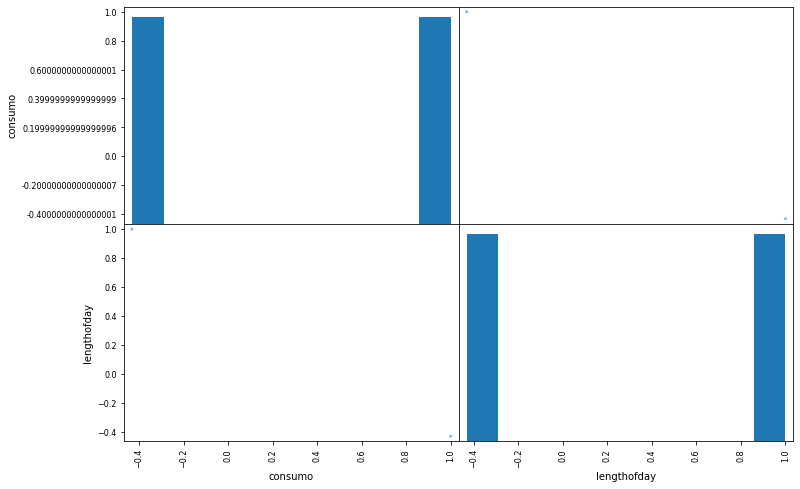

In [276]:
scatter_matrix(cm_e_sr, figsize = (12,8));

In [227]:
#Let's now compare external features to internal features.


In [261]:
intvsext = df_ohe.groupby(['DateTime', 'Phases_1_oh', 'Phases_2_oh',
       'Macrocluster_1_oh', 'Macrocluster_2_oh', 'Macrocluster_3_oh',
       'Macrocluster_4_oh', 'Macrocluster_5_oh', 'Macrocluster_6_oh',
       'Macrocluster_7_oh', 'PV_generation_1_oh', 'PV_generation_2_oh',
       'PV_generation_3_oh', 'PV_generation_4_oh', 'PV_generation_5_oh',
       'PV_generation_6_oh'])[['consumo','Contractual_power']].mean()

In [262]:
intvsext.head(100)

consumo  \
DateTime            Phases_1_oh Phases_2_oh Macrocluster_1_oh Macrocluster_2_oh Macrocluster_3_oh Macrocluster_4_oh Macrocluster_5_oh Macrocluster_6_oh Macrocluster_7_oh PV_generation_1_oh PV_generation_2_oh PV_generation_3_oh PV_generation_4_oh PV_generation_5_oh PV_generation_6_oh                
2017-10-01 00:00:00 0           1           0                 0                 0                 1                 0                 0                 0                 1                  0                  0                  0                  0                  0                   2777.000000   
                    1           0           0                 0                 0                 1                 0                 0                 0                 1                  0                  0                  0                  0                  0                    542.721550   
                                                                                1                 0                 0                 0                 0                 1                  0                  0                  0                  0                  0                    582.841060   
                                                              1                 0                 0                 0                 0                 0                 0                  0                  0                  0                  1                  0                    269.000000   
                                                                                                                                                                          1                  0                  0                  0                  0                  0                    416.835850   
...                                                                                                                                                                                                                                                                                                  ...   
2017-10-01 14:00:00 1           0           0                 1                 0                 0                 0                 0                 0                 1                  0                  0                  0                  0                  0                    383.501039   
                                            1                 0                 0                 0                 0                 0                 0                 1                  0                  0                  0                  0                  0                    170.372197   
2017-10-01 15:00:00 0           1           0                 0                 0                 0                 0                 1                 0                 1                  0                  0                  0                  0                  0                    168.000000   
                    1           0           0                 0                 0                 0                 0                 0                 1                 1                  0                  0                  0                  0                  0                    134.000000   
                                                                                                                    1                 0                 0                 1                  0                  0                  0                  0                  0                    167.000000   

                                                                                                                                                                                                                                                                                             Contractual_power  
DateTime            Phases_1_oh Phases_2_oh Macrocluster_1_oh Macrocluster_2_oh Mac

In [263]:
cross = pd.merge(intvsext,df_ohe_e,left_on=['DateTime'], right_on=['DateTime'], how='left')
cross.drop(columns=['consumo_y', 'DateTime_extF'], inplace=True)

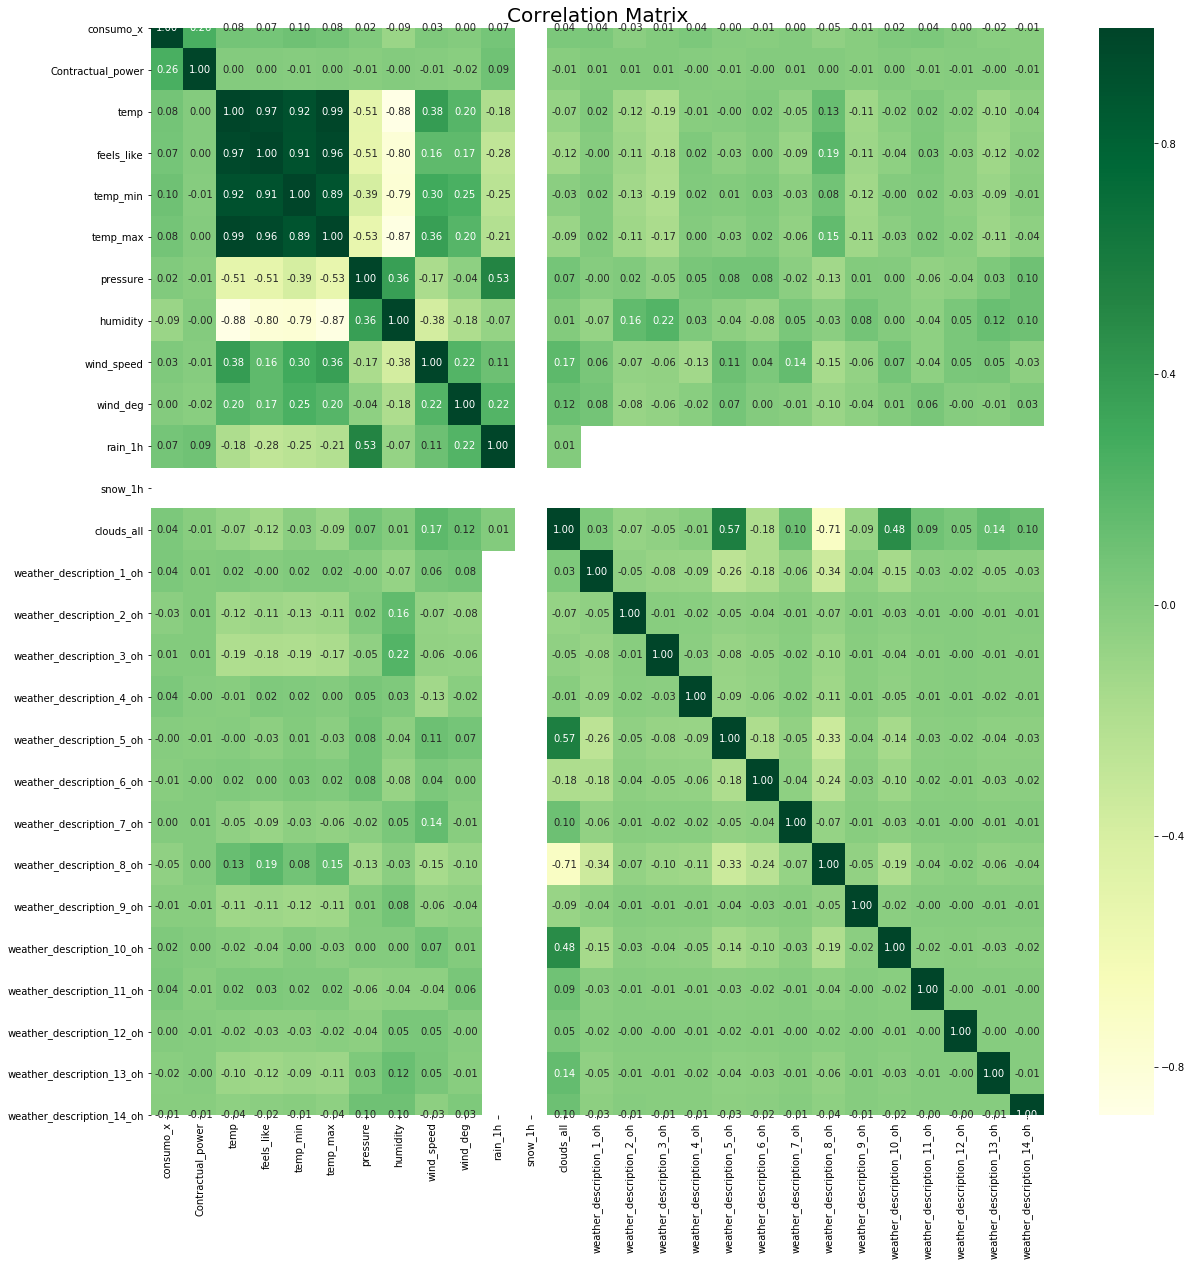

In [264]:
# Correlation Internal Vs External Features

plt.figure(figsize=(20,20))
cm_cross= cross.corr()
hm_cross = sns.heatmap(cm_cross, annot=True, fmt='.2f', cmap="YlGn")
hm_cross.set_title('Correlation Matrix', fontsize=20, y=1.02)

#plt.savefig("external_feat_corr.png")

plt.show()

In [265]:
cm_cross['consumo_x'].sort_values(ascending=False)

consumo_x                    1.000000
Contractual_power            0.263374
temp_min                     0.101894
temp                         0.076264
temp_max                     0.075617
feels_like                   0.070284
rain_1h                      0.068106
clouds_all                   0.042023
weather_description_11_oh    0.039514
weather_description_4_oh     0.038755
weather_description_1_oh     0.038362
wind_speed                   0.026633
weather_description_10_oh    0.024860
pressure                     0.017818
weather_description_3_oh     0.009520
wind_deg                     0.004729
weather_description_7_oh     0.003108
weather_description_12_oh    0.002384
weather_description_5_oh    -0.001984
weather_description_14_oh   -0.011549
weather_description_9_oh    -0.012058
weather_description_6_oh    -0.014318
weather_description_13_oh   -0.019967
weather_description_2_oh    -0.029585
weather_description_8_oh    -0.045595
humidity                    -0.091651
snow_1h     

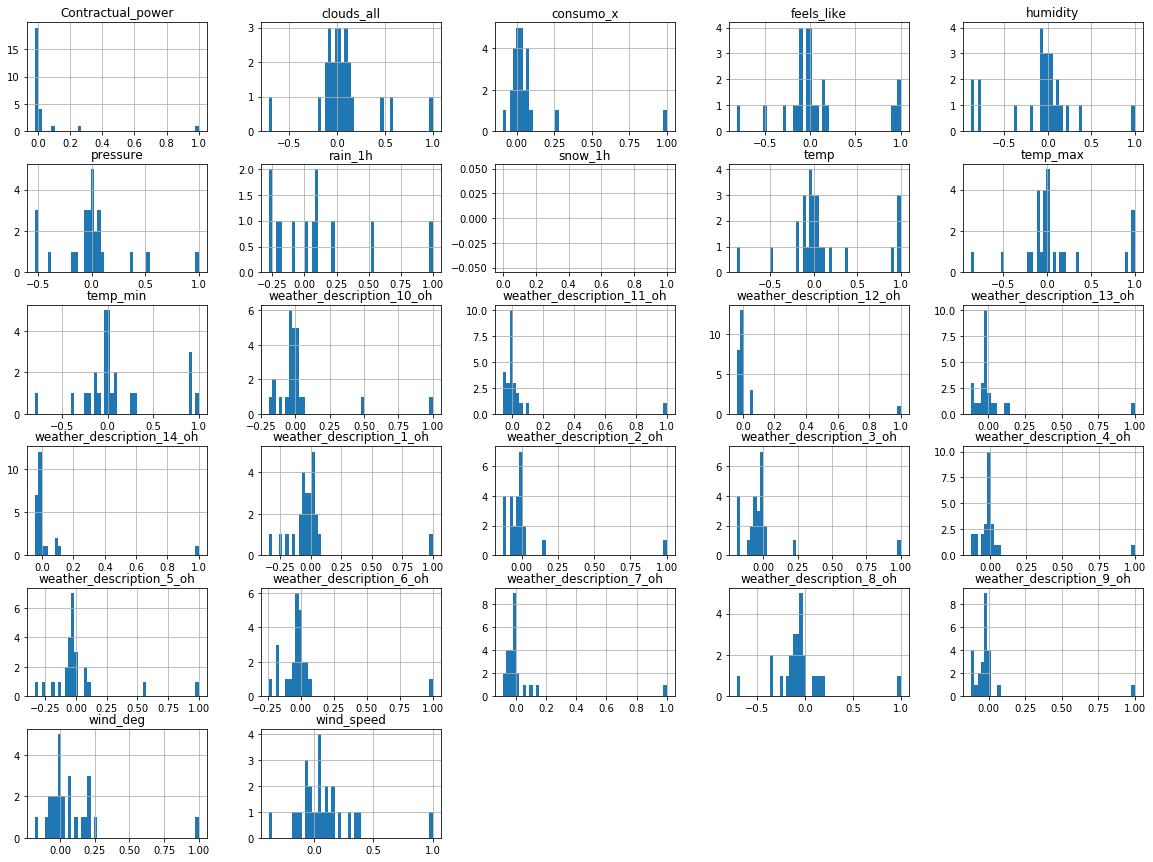

In [277]:
cm_cross.hist(bins=50, figsize=(20,15));

In [ ]:
# Let's measure Feature Importance and create a predictive model to correct nulls in the dataset
# train_set, test_set = train_test_split(df_raw, test_size = 0.2, random_state = 42)